<a href="https://colab.research.google.com/github/amdhacks/tensorflow/blob/master/income_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Richer syntax highlighting

Improved support for nested languages:

```notebook-python
df = pd.io.gbq.read_gbq('''
  SELECT 
    REGEXP_EXTRACT(name, '[a-zA-Z]+'),
    SUM(number) as count
  FROM `bigquery-public-data.usa_names.usa_1910_2013`
  WHERE state = 'TX'
  GROUP BY name
  ORDER BY count DESC
  LIMIT 100
''')
```

We will be using Tensorflow to solve this challenge although we can use any ML library to perform this like sckitlearn etc.

**Data Prepration**


In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [0]:
try:
  # Use the %tensorflow_version magic if in colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf

In [0]:
import numpy as np
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [51]:
#Upload source files
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving state1.csv to state1 (1).csv
Saving state2.csv to state2 (1).csv
Saving state3.csv to state3 (1).csv
Saving state4.csv to state4 (1).csv
User uploaded file "state1.csv" with length 4163 bytes
User uploaded file "state2.csv" with length 5050 bytes
User uploaded file "state3.csv" with length 4918 bytes
User uploaded file "state4.csv" with length 2956 bytes


In [0]:
#Reading source files
import pandas as pd
household=pd.read_csv('./state1.csv',skiprows=5)
family=pd.read_csv('./state2.csv',skiprows=4)
pci=pd.read_csv('./state3.csv')
gini=pd.read_csv('./state4.csv')

In [0]:
household.columns=['hou_state','hou_1999d','hou_1989cd','hou_1989_1999d','hou_1979cd','hou_1979_199d','hou_1969cd','hou_1969_1999d']



In [0]:
family.columns=['fam_state','fam_1999d','fam_1989cd','fam_1989_1999d','fam_1979cd','fam_1979_199d','fam_1969cd','fam_1969_1999d','fam_1959cd','fam_1959_1999d']


In [55]:
family.head(5)

,fam_state,fam_1999d,fam_1989cd,fam_1989_1999d,fam_1979cd,fam_1979_199d,fam_1969cd,fam_1969_1999d,fam_1959cd,fam_1959_1999d
0,State,1999,Current dollars,1999 dollars,Current dollars,1999 dollars,Current dollars,1999 dollars,Current dollars,1999 dollars
1,United States,"$50,046","$35,225","$45,956","$19,917","$42,609","$9,586","$37,559","$5,660","$27,632"
2,Alabama,"41,657","28,688","37,428","16,347","34,972","7,266","28,469","3,937","19,220"
3,Alaska,"59,036","46,581","60,772","28,395","60,747","12,441","48,746","7,305","35,663"
4,Arizona,"46,723","32,178","41,981","19,017","40,684","9,185","35,988","5,568","27,183"


In [0]:
#Rename Per Capita Income(PCI) columns
pci.columns=['pci_state','pci_1999d','pci_1989cd','pci_1989_1999d','pci_1979cd','pci_1979_1999d','pci_1969cd','pci_1969_1999d','pci_1959cd','pci_1959_1999d']


In [57]:
pci.head(5)

,pci_state,pci_1999d,pci_1989cd,pci_1989_1999d,pci_1979cd,pci_1979_1999d,pci_1969cd,pci_1969_1999d,pci_1959cd,pci_1959_1999d
0,State,1999,Current dollars,1999 dollars,Current dollars,1999 dollars,Current dollars,1999 dollars,Current dollars,1999 dollars
1,United States,"$21,587","$14,420","$18,715","$7,298","$15,523","$3,119","$12,151","$1,850","$8,980"
2,Alabama,"18,189","11,486","14,907","5,894","12,537","2,317","9,026","1,246","6,048"
3,Alaska,"22,660","17,610","22,855","10,193","21,681","3,725","14,511","2,259","10,965"
4,Arizona,"20,275","13,461","17,471","7,041","14,977","2,937","11,442","1,764","8,562"


In [0]:
#Rename Gini Ration Columns
gini.columns=['gini_state','gini_hou1999','gini_hou1989','gini_hou1979','gini_fam1999','gini_fam1989','gini_fam1979','gini_fam1969']


In [59]:
gini.head(5)

,gini_state,gini_hou1999,gini_hou1989,gini_hou1979,gini_fam1999,gini_fam1989,gini_fam1979,gini_fam1969
0,State,1999.000,1989.000,1979.000,1999.000,1989.000,1979,1969.000
1,United States,0.463,0.445,0.415,0.434,0.414,(NA),0.361
2,Alabama,0.475,0.458,0.427,0.435,0.418,0.385,0.393
3,Alaska,0.402,0.397,0.393,0.377,0.387,0.369,0.366
4,Arizona,0.450,0.439,0.399,0.429,0.413,0.365,0.363


In [0]:
#Drop first two lines from each dataframe as we create columns and also we dont need united states data for 
household.drop([0,1],axis=0,inplace=True)
family.drop([0,1],axis=0,inplace=True)
pci.drop([0,1],axis=0,inplace=True)
gini.drop([0,1],axis=0,inplace=True)


In [0]:
#Drop na values
gini.dropna(how='any',thresh=2,axis=0,inplace=True)
household.dropna(how='any',thresh=2,axis=0,inplace=True)
family.dropna(how='any',thresh=2,axis=0,inplace=True)
pci.dropna(how='any',thresh=2,axis=0,inplace=True)



In [62]:
#Find how many rows are in each dataframe. All of the data frames should have same number of rows for correct mapping of columns
print('Row count in household',len(household))
print('Row count in family',len(family))
print('Row count in pci',len(pci))
print('Row count in gini',len(gini))


Row count in household 51
Row count in family 51
Row count in pci 51
Row count in gini 51


In [0]:
#Concatenate column all the source file dataframes to create a unified dataframe
sourcedata=pd.concat([household,family,pci,gini],axis=1)

In [0]:
#Removing all the commas
for col in sourcedata.columns:
    sourcedata[col] = sourcedata[col].apply(lambda x:str(x).replace(',',''))

In [65]:
sourcedata.head(5)

,hou_state,hou_1999d,hou_1989cd,hou_1989_1999d,hou_1979cd,hou_1979_199d,hou_1969cd,hou_1969_1999d,fam_state,fam_1999d,fam_1989cd,fam_1989_1999d,fam_1979cd,fam_1979_199d,fam_1969cd,fam_1969_1999d,fam_1959cd,fam_1959_1999d,pci_state,pci_1999d,pci_1989cd,pci_1989_1999d,pci_1979cd,pci_1979_1999d,pci_1969cd,pci_1969_1999d,pci_1959cd,pci_1959_1999d,gini_state,gini_hou1999,gini_hou1989,gini_hou1979,gini_fam1999,gini_fam1989,gini_fam1979,gini_fam1969
2,Alabama,34135,23597,30786,13669,29243,6419,25151,Alabama,41657,28688,37428,16347,34972,7266,28469,3937,19220,Alabama,18189,11486,14907,5894,12537,2317,9026,1246,6048,Alabama,0.475,0.45799999999999996,0.42700000000000005,0.435,0.418,0.385,0.39299999999999996
3,Alaska,51571,41408,54023,25414,54369,11817,46301,Alaska,59036,46581,60772,28395,60747,12441,48746,7305,35663,Alaska,22660,17610,22855,10193,21681,3725,14511,2259,10965,Alaska,0.402,0.397,0.39299999999999996,0.377,0.387,0.369,0.366
4,Arizona,40558,27540,35930,16448,35188,8199,32125,Arizona,46723,32178,41981,19017,40684,9185,35988,5568,27183,Arizona,20275,13461,17471,7041,14977,2937,11442,1764,8562,Arizona,0.45,0.439,0.39899999999999997,0.429,0.413,0.365,0.363
5,Arkansas,32182,21147,27589,12214,26130,5356,20986,Arkansas,38663,25395,33132,14641,31322,6271,24571,3184,15544,Arkansas,16904,10520,13653,5614,11941,2142,8345,1125,5461,Arkansas,0.45799999999999996,0.45,0.428,0.42200000000000004,0.405,0.389,0.40399999999999997
6,California,47493,35798,46704,18243,39028,9302,36447,California,53025,40559,52915,21537,46075,10729,42038,6726,32836,California,22711,16409,21297,8295,17644,3614,14079,2308,11203,California,0.475,0.441,0.408,0.45799999999999996,0.42200000000000004,0.372,0.35700000000000004


In [0]:
#Rounding off the gini values to 3 decimal places
for col in ['gini_hou1999', 'gini_hou1989', 'gini_hou1979', 'gini_fam1999', 'gini_fam1989', 'gini_fam1979', 'gini_fam1969']:
  sourcedata[col]=sourcedata[col].astype(float).round(3)

for col1 in ['pci_1999d', 'pci_1989cd',
       'pci_1989_1999d', 'pci_1979cd', 'pci_1979_1999d', 'pci_1969cd',
       'pci_1969_1999d', 'pci_1959cd', 'pci_1959_1999d']:
  sourcedata[col1]=sourcedata[col1].astype(float)

In [67]:
sourcedata.columns

Index(['hou_state', 'hou_1999d', 'hou_1989cd', 'hou_1989_1999d', 'hou_1979cd',
       'hou_1979_199d', 'hou_1969cd', 'hou_1969_1999d', 'fam_state',
       'fam_1999d', 'fam_1989cd', 'fam_1989_1999d', 'fam_1979cd',
       'fam_1979_199d', 'fam_1969cd', 'fam_1969_1999d', 'fam_1959cd',
       'fam_1959_1999d', 'pci_state', 'pci_1999d', 'pci_1989cd',
       'pci_1989_1999d', 'pci_1979cd', 'pci_1979_1999d', 'pci_1969cd',
       'pci_1969_1999d', 'pci_1959cd', 'pci_1959_1999d', 'gini_state',
       'gini_hou1999', 'gini_hou1989', 'gini_hou1979', 'gini_fam1999',
       'gini_fam1989', 'gini_fam1979', 'gini_fam1969'],
      dtype='object')

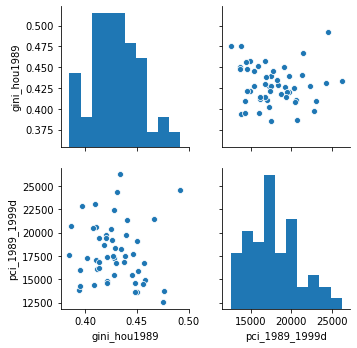

In [68]:
#Data Exploration
import seaborn as sns

sns.pairplot(sourcedata[["gini_hou1989","pci_1989_1999d",]])


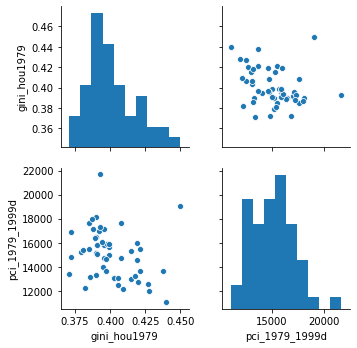

In [69]:
#For Decade 1979
sns.pairplot(sourcedata[["gini_hou1979","pci_1979_1999d",]])


In [0]:
#Make first row as header and then drop it
#gini.columns=gini.loc[0]

In [0]:
#gini.drop(0,axis=0,inplace=True)
#Drop row0 and row1 with united states data as well as do no need for this solution
#gini.drop(1,axis=0,inplace=True)


In [0]:
#Drop missing values
#gini.dropna(axis=0,how='any',inplace=True)

**Pre-Processing**

In [0]:
#All gini data
all_gini=sourcedata['gini_hou1999'].append(sourcedata['gini_hou1989'].append(sourcedata['gini_hou1979']))

In [0]:
#All pci data
all_pci=sourcedata['pci_1999d'].append(sourcedata['pci_1989_1999d'].append(sourcedata['pci_1979_1999d']))


In [81]:
len(all_pci)

153

In [0]:
#gini_data1=gini_data1.reset_index(drop=True)
#pci_data1=pci_data1.reset_index(drop=True)

In [0]:
#Lets map the two pandas series
#gini_pci_data=pd.DataFrame({'gini':gini_data1,'pci':pci_data1})


In [0]:
#gini_pci_data.head

In [0]:
#gini_pci_data['pci']=gini_pci_data['pci'].apply(lambda x:x.replace(',',''))

In [0]:
#Shuffle data set
from sklearn.utils import shuffle
dataset = shuffle(sourcedata)

In [86]:
dataset.head()

,hou_state,hou_1999d,hou_1989cd,hou_1989_1999d,hou_1979cd,hou_1979_199d,hou_1969cd,hou_1969_1999d,fam_state,fam_1999d,fam_1989cd,fam_1989_1999d,fam_1979cd,fam_1979_199d,fam_1969cd,fam_1969_1999d,fam_1959cd,fam_1959_1999d,pci_state,pci_1999d,pci_1989cd,pci_1989_1999d,pci_1979cd,pci_1979_1999d,pci_1969cd,pci_1969_1999d,pci_1959cd,pci_1959_1999d,gini_state,gini_hou1999,gini_hou1989,gini_hou1979,gini_fam1999,gini_fam1989,gini_fam1979,gini_fam1969
21,Maine,37240,27854,36340,13816,29557,7315,28661,Maine,45179,32422,42299,16167,34587,8205,32148,4873,23790,Maine,19533.0,12957.0,16816.0,5768.0,12269.0,2548.0,9926.0,1514.0,7349.0,Maine,0.434,0.414,0.382,0.396,0.373,0.342,0.328
25,Minnesota,47111,30909,40325,17761,37997,8753,34295,Minnesota,56874,36916,48162,21185,45322,9928,38899,5573,27207,Minnesota,23198.0,14389.0,18675.0,7451.0,15849.0,3038.0,11835.0,1734.0,8417.0,Minnesota,0.426,0.418,0.391,0.387,0.379,0.346,0.346
15,Illinois,46590,32252,42078,19321,41334,9706,38029,Illinois,55545,38664,50443,22746,48662,10957,42931,6566,32055,Illinois,23104.0,15201.0,19729.0,8066.0,17157.0,3495.0,13615.0,2182.0,10591.0,Illinois,0.456,0.440,0.396,0.425,0.407,0.352,0.342
13,Hawaii,49820,38829,50658,20473,43799,10675,41826,Hawaii,56961,43176,56330,22750,48670,11552,45262,6366,31079,Hawaii,21525.0,15770.0,20467.0,7740.0,16464.0,3373.0,13140.0,1863.0,9043.0,Hawaii,0.434,0.408,0.390,0.401,0.381,0.365,0.353
18,Kansas,40624,27291,35605,16362,35004,7578,29692,Kansas,49624,32966,43009,19707,42160,8690,34049,5295,25850,Kansas,20506.0,13300.0,17262.0,7350.0,15634.0,2929.0,11410.0,1775.0,8616.0,Kansas,0.435,0.428,0.399,0.396,0.388,0.353,0.362


In [0]:
#Create dataset for training and teting
x_train=all_gini.head(120)
y_train=all_pci.head(120)

In [0]:
x_test= all_gini.tail(33)
y_test=all_pci.tail(33)

In [101]:
from tensorflow import keras
from tensorflow.keras import layers
#Define Keras Layers-3 layers here  for Neural network
l0 = tf.keras.layers.Dense(units=4, input_shape=[1])
l1 = tf.keras.layers.Dense(units=4)
l2 = tf.keras.layers.Dense(units=1)
model = tf.keras.Sequential([l0, l1, l2])
#model = tf.keras.Sequential([l0])

model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(0.1))
history=model.fit(x_train, y_train, epochs=2000, verbose=False)
print("Finished training the model")
print(model.predict([.545]))



Finished training the model
[[23163.168]]


In [102]:
#Use the model to predict
print(model.predict([.990]))

[[40388.047]]


In [99]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 4)                 484       
_________________________________________________________________
dense_13 (Dense)             (None, 4)                 20        
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 5         
Total params: 509
Trainable params: 509
Non-trainable params: 0
_________________________________________________________________


In [100]:
#Visualize the model's training progress using the stats stored in the history object.
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()


,loss,val_loss,epoch
995,1.157186e+07,15106304.0,995
996,1.150324e+07,14348075.0,996
997,1.158482e+07,12813781.0,997
998,1.155979e+07,12882751.0,998
999,1.154023e+07,14058417.0,999


In [0]:
#Flatten y_test
y_test=y_test.ravel()

In [0]:
#Flaten x_test
x_test=x_test.ravel()

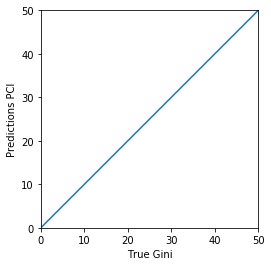

In [95]:
#Make predictions
import matplotlib.pyplot as plt
test_predictions = model.predict(x_test).flatten()

a = plt.axes(aspect='equal')
plt.scatter(y_test, test_predictions)
plt.xlabel('True Gini')
plt.ylabel('Predictions PCI')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

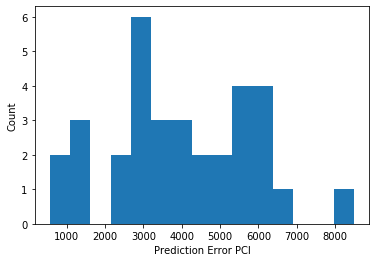

In [96]:
error = test_predictions - y_test
plt.hist(error, bins = 15)
plt.xlabel("Prediction Error PCI")
plot = plt.ylabel("Count")